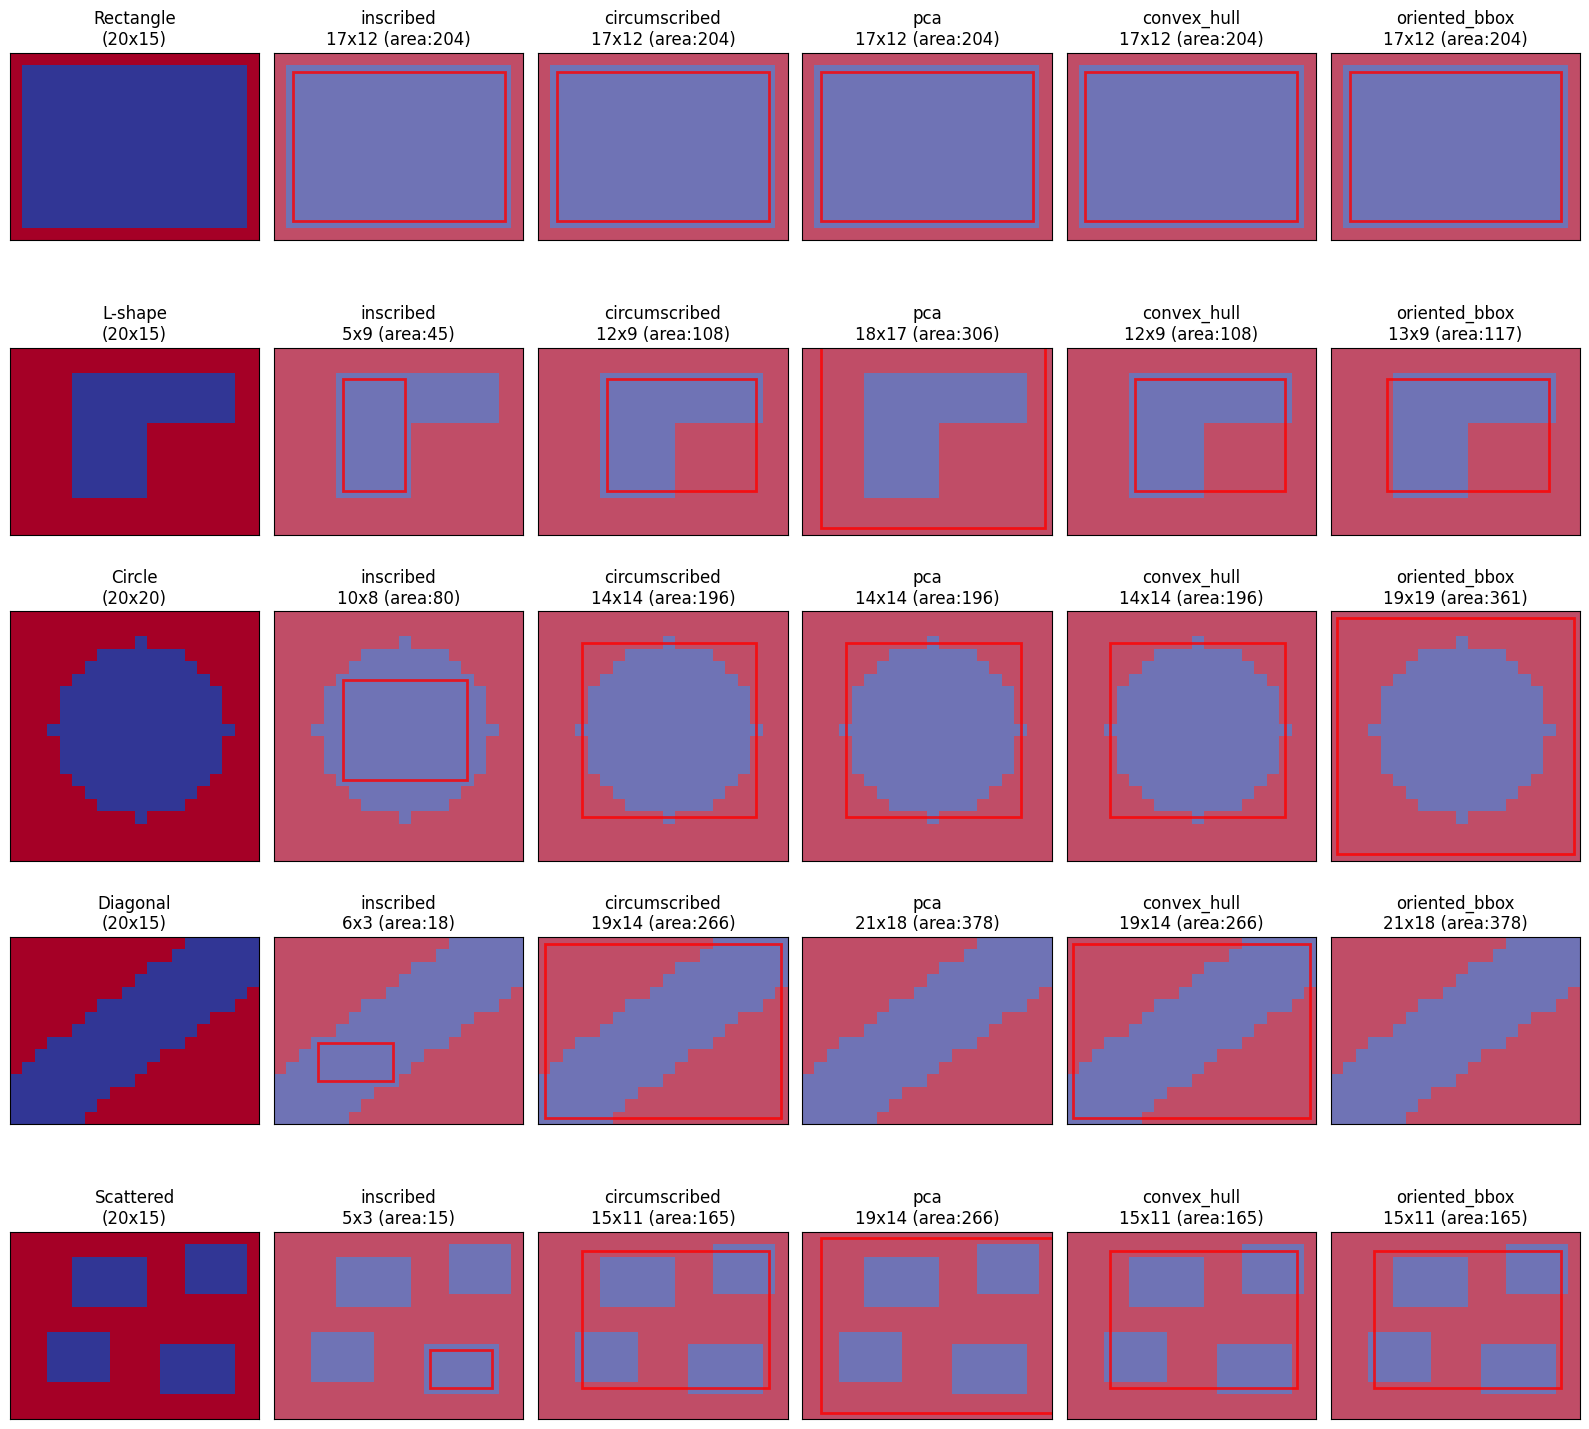

L-shape open space (20x15) comparison:
--------------------------------------------------
inscribed      :  5x 9 =  45
circumscribed  : 12x 9 = 108
pca            : 18x17 = 306
convex_hull    : 12x 9 = 108
oriented_bbox  : 13x 9 = 117


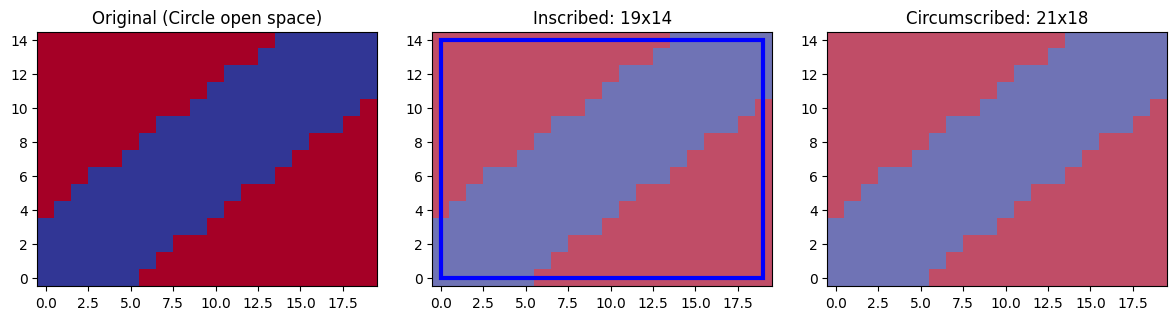

In [ ]:
# %% [markdown]
# # Open Space Rectangle Approximation - Minimal Test
# 다양한 open space 모양에서 사각형 근사화 테스트

# %%
import numpy as np
import matplotlib.pyplot as plt
from osc import approximate_open_space_rectangle

# 한글 폰트 설정 (warning 해결)
plt.rcParams['font.family'] = 'DejaVu Sans'
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# %%
def create_rectangle_space():
    """직사각형 open space"""
    nx, ny = 20, 15
    obs_pos = []
    # 테두리만 장애물
    for i in range(nx):
        obs_pos.extend([i, (ny-1)*nx + i])
    for i in range(1, ny-1):
        obs_pos.extend([i*nx, i*nx + (nx-1)])
    return nx, ny, obs_pos

def create_l_shape():
    """L자형 open space"""
    nx, ny = 20, 15
    obs_pos = []
    for i in range(ny):
        for j in range(nx):
            # L자 패턴 (세로 + 가로)
            vertical = (j >= 5 and j <= 10 and i >= 3 and i <= 12)
            horizontal = (j >= 10 and j <= 17 and i >= 9 and i <= 12)
            if not (vertical or horizontal):
                obs_pos.append(i * nx + j)
    return nx, ny, obs_pos

def create_circle_shape():
    """원형 open space"""
    nx, ny = 20, 20
    obs_pos = []
    center_x, center_y = 10, 10
    radius = 7
    for i in range(ny):
        for j in range(nx):
            if (j - center_x)**2 + (i - center_y)**2 > radius**2:
                obs_pos.append(i * nx + j)
    return nx, ny, obs_pos

def create_diagonal_shape():
    """대각선 띠 모양"""
    nx, ny = 20, 15
    obs_pos = []
    for i in range(ny):
        for j in range(nx):
            if abs(j - i * nx/ny) > 5:  # 대각선 띠
                obs_pos.append(i * nx + j)
    return nx, ny, obs_pos

def create_scattered_shape():
    """분산된 작은 영역들"""
    nx, ny = 20, 15
    obs_pos = list(range(nx * ny))
    # 작은 사각형들을 open space로
    regions = [(3,3,7,6), (12,2,17,5), (5,9,10,12), (14,10,18,13)]
    for min_x, min_y, max_x, max_y in regions:
        for i in range(min_y, max_y+1):
            for j in range(min_x, max_x+1):
                if 0 <= i < ny and 0 <= j < nx:
                    obs_pos.remove(i * nx + j)
    return nx, ny, obs_pos

# %%
def test_all_shapes():
    """모든 모양 테스트"""
    shapes = [
        ("Rectangle", create_rectangle_space),
        ("L-shape", create_l_shape), 
        ("Circle", create_circle_shape),
        ("Diagonal", create_diagonal_shape),
        ("Scattered", create_scattered_shape)
    ]
    
    methods = ["inscribed", "circumscribed", "pca", "convex_hull", "oriented_bbox"]
    
    fig, axes = plt.subplots(len(shapes), len(methods)+1, figsize=(16, 3*len(shapes)))
    
    for i, (name, create_func) in enumerate(shapes):
        nx, ny, obs_pos = create_func()
        
        # 원본 그리드 표시
        ax = axes[i, 0]
        grid = np.ones((ny, nx))
        for obs in obs_pos:
            row, col = obs // nx, obs % nx
            grid[row, col] = 0
        ax.imshow(grid, cmap='RdYlBu', origin='lower')
        ax.set_title(f'{name}\n({nx}x{ny})')
        ax.set_xticks([])
        ax.set_yticks([])
        
        # 각 방법별 결과
        for j, method in enumerate(methods):
            ax = axes[i, j+1]
            ax.imshow(grid, cmap='RdYlBu', origin='lower', alpha=0.7)
            
            try:
                rect = approximate_open_space_rectangle(nx, ny, obs_pos, method)
                min_col, min_row, max_col, max_row = map(int, rect)
                width, height = max_col - min_col, max_row - min_row
                
                # 정확한 좌표 맞추기 (imshow 픽셀 중심 기준)
                rect_patch = plt.Rectangle((min_col, min_row), width, height,
                                         fill=False, edgecolor='red', linewidth=2, alpha=0.8)
                ax.add_patch(rect_patch)
                ax.set_title(f'{method}\n{width}x{height} (area:{width*height})')
                
            except Exception as e:
                ax.set_title(f'{method}\nError')
            
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.tight_layout()
    plt.show()

# %%
# 테스트 실행
test_all_shapes()

# %%
def compare_methods_single_shape():
    """하나 모양에서 모든 방법 비교"""
    nx, ny, obs_pos = create_l_shape()  # L자 모양 사용
    
    methods = ["inscribed", "circumscribed", "pca", "convex_hull", "oriented_bbox"]
    
    print(f"L-shape open space ({nx}x{ny}) comparison:")
    print("-" * 50)
    
    for method in methods:
        try:
            rect = approximate_open_space_rectangle(nx, ny, obs_pos, method)
            min_col, min_row, max_col, max_row = map(int, rect)
            width, height = max_col - min_col, max_row - min_row
            area = width * height
            print(f"{method:15}: {width:2d}x{height:2d} = {area:3d}")
        except Exception as e:
            print(f"{method:15}: Error - {str(e)[:30]}")

# %%
# 단일 모양 비교
compare_methods_single_shape()

# %%
def visualize_one_case():
    """하나 케이스 자세히 보기"""
    nx, ny, obs_pos = create_diagonal_shape()
    
    plt.figure(figsize=(12, 4))
    
    # 원본
    plt.subplot(1, 3, 1)
    grid = np.ones((ny, nx))
    for obs in obs_pos:
        row, col = obs // nx, obs % nx
        grid[row, col] = 0
    plt.imshow(grid, cmap='RdYlBu', origin='lower')
    plt.title('Original (Circle open space)')
    
    # Inscribed
    plt.subplot(1, 3, 2)
    plt.imshow(grid, cmap='RdYlBu', origin='lower', alpha=0.7)
    rect = approximate_open_space_rectangle(nx, ny, obs_pos, "circumscribed")
    min_col, min_row, max_col, max_row = map(int, rect)
    width, height = max_col - min_col, max_row - min_row
    rect_patch = plt.Rectangle((min_col, min_row), width, height,
                             fill=False, edgecolor='blue', linewidth=3)
    plt.gca().add_patch(rect_patch)
    plt.title(f'Circumscribed: {width}x{height}')
    
    # Circumscribed
    plt.subplot(1, 3, 3)
    plt.imshow(grid, cmap='RdYlBu', origin='lower', alpha=0.7)
    rect = approximate_open_space_rectangle(nx, ny, obs_pos, "oriented_bbox")
    min_col, min_row, max_col, max_row = map(int, rect)
    width, height = max_col - min_col, max_row - min_row
    rect_patch = plt.Rectangle((min_col, min_row), width, height,
                             fill=False, edgecolor='red', linewidth=3)
    plt.gca().add_patch(rect_patch)
    plt.title(f'Oriented bbox: {width}x{height}')
    
    plt.tight_layout()
    plt.show()

# %%
# 자세한 케이스 보기
visualize_one_case()